In [41]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import matplotlib.pyplot as plt
import os
import joblib

os.chdir('absolute-path-to-root')


In [42]:
df = pd.read_csv("./data/generated_asian_option_data.csv")
X = df[["S0", "r", "T", "K", "sigma"]].values
y = df["price"].values.reshape(-1, 1)

feature_scaler = StandardScaler()
label_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X_train)
y_scaled = label_scaler.fit_transform(y_train)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

device = "cuda" if torch.cuda.is_available() else "cpu"
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)
X_val_t = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val_t = torch.tensor(y_val, dtype=torch.float32, device=device)

In [43]:
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    
    layers = []
    input_dim = 5
    for i in range(num_layers):
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        input_dim = hidden_dim
    layers.append(nn.Linear(hidden_dim, 1))
    
    model = nn.Sequential(*layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_t, y_train_t),
        batch_size=batch_size,
        shuffle=True
    )
    
    epochs = 200
    best_val_loss = float("inf")
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        epoch_loss /= len(X_train_t)
        
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = criterion(val_pred, y_val_t)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
                
        trial.report(val_loss.item(), epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
    return best_val_loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.6f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-01-08 21:26:39,936] A new study created in memory with name: no-name-bbdff573-54be-42c6-a9f6-6334dd9e02d2


[I 2025-01-08 21:26:49,688] Trial 0 finished with value: 0.0005353487213142216 and parameters: {'hidden_dim': 48, 'num_layers': 3, 'learning_rate': 1.0931261968752986e-05, 'batch_size': 16}. Best is trial 0 with value: 0.0005353487213142216.
[I 2025-01-08 21:26:50,393] Trial 1 finished with value: 0.0001350315724266693 and parameters: {'hidden_dim': 127, 'num_layers': 4, 'learning_rate': 0.00934379005684168, 'batch_size': 128}. Best is trial 1 with value: 0.0001350315724266693.
[I 2025-01-08 21:26:51,273] Trial 2 finished with value: 0.00013594342453870922 and parameters: {'hidden_dim': 174, 'num_layers': 4, 'learning_rate': 0.007493189836435085, 'batch_size': 128}. Best is trial 1 with value: 0.0001350315724266693.
[I 2025-01-08 21:26:54,266] Trial 3 finished with value: 0.00042493187356740236 and parameters: {'hidden_dim': 110, 'num_layers': 3, 'learning_rate': 2.31015970705641e-05, 'batch_size': 128}. Best is trial 1 with value: 0.0001350315724266693.
[I 2025-01-08 21:26:55,308] Tri

Best trial:
  Value: 0.000045
  Params: 
    hidden_dim: 256
    num_layers: 2
    learning_rate: 0.000872086910758614
    batch_size: 64


In [44]:
class AsianOptionNN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

best_params = trial.params
final_model = AsianOptionNN(
    input_dim=5,
    hidden_dim=best_params["hidden_dim"]
).to(device)

optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss()
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_t, y_train_t),
    batch_size=best_params["batch_size"],
    shuffle=True
)

epochs = 200
best_val_loss = float("inf")
patience = 10
patience_counter = 0

training_losses = []
validation_losses = []

for epoch in range(epochs):
    final_model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = final_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    epoch_loss /= len(X_train_t)
    training_losses.append(epoch_loss)
    
    final_model.eval()
    with torch.no_grad():
        val_pred = final_model(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()
        validation_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

Final model saved to ./models/asian_option_pricer.pt


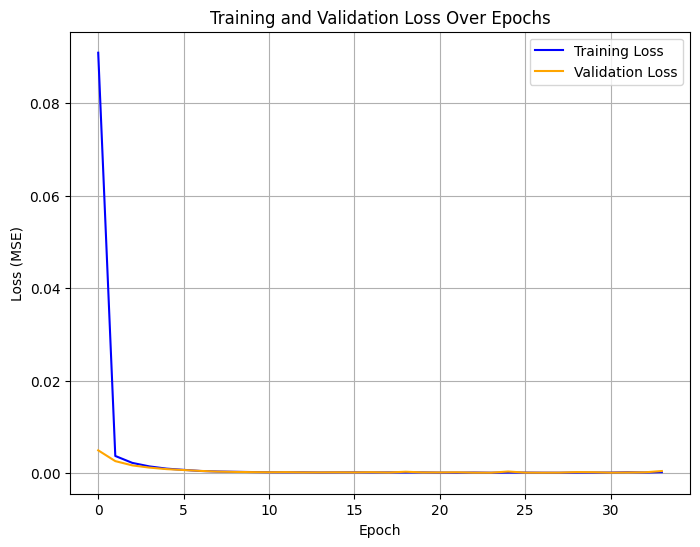

In [45]:
torch.save(final_model.state_dict(), "./models/asian_option_pricer.pt")
print("Final model saved to ./models/asian_option_pricer.pt")

joblib.dump(feature_scaler, "./models/feature_scaler.pkl")
joblib.dump(label_scaler, "./models/label_scaler.pkl")

plt.figure(figsize=(8, 6))
plt.plot(training_losses, label='Training Loss', color='blue')
plt.plot(validation_losses, label='Validation Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.savefig("./plots/loss_curves.png")
plt.show()